In [95]:
import numpy as np

data = np.random.rand(1000, 25)

In [96]:
kNeighbors = 5

In [97]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=kNeighbors+1, algorithm='auto').fit(data)

distances, indices = knn.kneighbors(data, n_neighbors=kNeighbors+1, return_distance=True)

In [98]:
neighborDistances, neighborIndices = distances[:, 1:], indices[:, 1:]
closestNeighborDistance, closestNeighborIndex = neighborDistances[:, 0], neighborIndices[:, 0]

In [99]:
targetSigma = np.log(kNeighbors)

In [100]:
def binarySearchSigma(neighborDistances, closestNeighborDistance, targetSigma, lowerBoundSigma = 1e-5, upperBoundSigma = 1000, tolerance = 1e-5, maxIters=64):
    # computing sigma per node and neighbors to approximate probability such that every node has roughly same probability with its neighbors

    sigma = np.full((neighborDistances.shape[0], 1), (lowerBoundSigma + upperBoundSigma)/2)

    for idx,(distances,closestDistance) in enumerate(zip(neighborDistances, closestNeighborDistance)):
        lower = lowerBoundSigma
        upper = upperBoundSigma
        iters = 0

        while iters < maxIters:
            result = computeFuzzyProbability(distances, closestDistance, sigma[idx]).sum()

            if np.abs(result - targetSigma) < tolerance:
                break
            elif result < targetSigma:
                upper = sigma[idx]
                sigma[idx] = (lower + sigma[idx])/2
            else:
                lower = sigma[idx]
                sigma[idx] = (sigma[idx] + upper)/2

            iters += 1

    return sigma

def computeFuzzyProbability(distances, closestDistance, sigma):
    return np.exp(-((distances - closestDistance)/sigma))

# def computeDirectedFuzzyGraph(neighborDistances, closestNeighborDistance, sigma):
#     fuzzyProbabilities = computeFuzzyProbability(neighborDistances, closestNeighborDistance, sigma)
#     return fuzzyProbabilities


In [101]:
from scipy.sparse import coo_matrix, csr_matrix

def symmetricFuzzyGraph(fuzzyProbabilities, neighborIndices, kNeighbors):
    n_samples = fuzzyProbabilities.shape[0]

    rows = np.repeat(np.arange(n_samples), kNeighbors)
    cols = neighborIndices.flatten()
    data = fuzzyProbabilities.flatten()

    P_ji = coo_matrix((data, (rows, cols)), shape=(n_samples, n_samples))
    ones = csr_matrix(np.ones(P_ji.shape))

    # this is Pr(a OR b) so the probability that at least one happens.
    # this means we're looking for edges where at least one OR both think the other is close and combining their opinions of the strength of the connection
    P = ones - (ones - P_ji).multiply(ones - P_ji.T)

    return P.tocoo()

In [102]:
import numpy as np

initialPoints = np.random.normal(loc=0, scale=0.0001, size=(data.shape[0], 2))


In [147]:
import torch

def lowDimensionEmbeddingProbabilities(points, a=1.929, b=0.7915):
    d = torch.linalg.norm(points[:, 0] - points[:, 1], dim=1)
    qij = 1/(1 + a * d**(2*b))
    return qij

In [148]:
import torch

def umap_loss(positiveValues, negativeValues, gamma, a=1.929, b=0.7915):
    eps = 1e-4  # or smaller
    q_pos = torch.clamp(lowDimensionEmbeddingProbabilities(positiveValues, a, b), min=eps)
    q_neg = torch.clamp(lowDimensionEmbeddingProbabilities(negativeValues, a, b), max=1 - eps)

    '''
    For the first term - nodes that SHOULD be close together
    - when the distance is close we get return value from lowDimensionEmbeddingProbabilities that is close to 1
        - log of close to 1 is small negative, flip it to small positive loss
    - when the distance is far away we get return value from lowDimensionEmbeddingProbabilities that is close to 0
        - log of close to 0 is large negative, flip it to large positive loss

    For the second term - nodes that SHOULD be far away
    - when the distance is close we get return value from lowDimensionEmbeddingProbabilities that is close to 1
        - (1 - close to 1) is 0, then log of 0 is big negative, flip it to big positive loss
    - when the distance is far away we get return value from lowDimensionEmbeddingProbabilities that is close to 0
        - (1 - close to 0) is 1, then log of 1 is small negative, flip it to small positive loss
    '''
    firstTerm = -torch.log(q_pos).sum()
    secondTerm = -gamma * torch.log(1 - q_neg).sum()
    return firstTerm + secondTerm

In [149]:
def samplePositivePairs(fuzzyGraphMatrix, batch_size):
    row_indices = fuzzyGraphMatrix.row
    col_indices = fuzzyGraphMatrix.col
    values = fuzzyGraphMatrix.data

    positive_pairs  = np.stack([row_indices, col_indices], axis=1)
    positive_weights = values

    mask = row_indices < col_indices
    positive_pairs  = positive_pairs[mask]
    positive_weights = positive_weights[mask]

    # this is the correct way to sample probability because we want to sample probability of important edges GLOBALLY
    # more important edges GLOBALLY should matter more not just on a local level
    probabilities = positive_weights / positive_weights.sum()
    indices = np.random.choice(len(positive_pairs), size=batch_size, p=probabilities)
    batch = positive_pairs[indices]

    return batch

def sampleNegativePairs(fuzzyGraphMatrix, batch_size):
    n_points = fuzzyGraphMatrix.shape[0]

    negative_mask = np.ones((n_points, n_points), dtype=bool)
    negative_mask[fuzzyGraphMatrix.row, fuzzyGraphMatrix.col] = False
    negative_mask[fuzzyGraphMatrix.col, fuzzyGraphMatrix.row] = False  # make it symmetric
    np.fill_diagonal(negative_mask, False)  # avoid self-pairs

    neg_pairs = []
    while len(neg_pairs) < batch_size:
        i = np.random.randint(0, n_points, size=batch_size)
        j = np.random.randint(0, n_points, size=batch_size)

        # giving us the values at i,j
        mask = negative_mask[i, j]
        # only getting the values that are true
        i = i[mask]
        j = j[mask]

        neg_pairs.append(np.stack([i, j], axis=1))

    return np.concatenate(neg_pairs, axis=0)[:batch_size]


In [169]:
def umapOptimizationLoop(symmetricFuzzyGraphMatrix, embedding, num_epochs, batch_size, a=1.929, b=0.7915):
    optimizer = torch.optim.Adam([embedding], lr=1e-2)

    for step in range(num_epochs):
        pos_pairs = samplePositivePairs(symmetricFuzzyGraphMatrix, batch_size)
        neg_pairs = sampleNegativePairs(symmetricFuzzyGraphMatrix, batch_size)

        pos_coords = embedding[pos_pairs]
        neg_coords = embedding[neg_pairs]

        loss = umap_loss(pos_coords, neg_coords, gamma=5.0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 10 == 0:
            print(f"Step {step}, loss = {loss.item():.4f}")

    return embedding


In [144]:
sigma = binarySearchSigma(neighborDistances, closestNeighborDistance, targetSigma)
fuzzyProbabilities = computeFuzzyProbability(neighborDistances, closestNeighborDistance.reshape(-1, 1), sigma)

P = symmetricFuzzyGraph(fuzzyProbabilities, neighborIndices, kNeighbors)


In [158]:
import torch

embedding = torch.tensor(initialPoints, dtype=torch.float32, requires_grad=True)
print(embedding.shape)


torch.Size([1000, 2])


In [171]:
from umap.umap_ import find_ab_params
a, b = find_ab_params(spread=1.0, min_dist=0.1)  # match the library default
embedding = umapOptimizationLoop(P, embedding, num_epochs=1000, batch_size=1000, a=a, b=b)

Step 0, loss = 3530.7676
Step 10, loss = 3488.0513
Step 20, loss = 3325.7915
Step 30, loss = 3484.0596
Step 40, loss = 3222.8521
Step 50, loss = 3351.7036
Step 60, loss = 3243.8030
Step 70, loss = 3190.3596
Step 80, loss = 3314.6255
Step 90, loss = 3350.4910
Step 100, loss = 3200.1409
Step 110, loss = 3205.1138
Step 120, loss = 3161.3784
Step 130, loss = 3215.2888
Step 140, loss = 3159.4624
Step 150, loss = 3059.8696
Step 160, loss = 3115.1289
Step 170, loss = 3058.0830
Step 180, loss = 3133.0068
Step 190, loss = 3181.6401
Step 200, loss = 3016.3945
Step 210, loss = 3062.3062
Step 220, loss = 3015.0869
Step 230, loss = 3090.8391
Step 240, loss = 3032.6060
Step 250, loss = 2960.5391
Step 260, loss = 3060.8499
Step 270, loss = 2931.4717
Step 280, loss = 3076.2954
Step 290, loss = 2975.8982
Step 300, loss = 3006.4771
Step 310, loss = 3048.2126
Step 320, loss = 3059.6011
Step 330, loss = 3009.1992
Step 340, loss = 2948.5864
Step 350, loss = 2943.3640
Step 360, loss = 2985.6206
Step 370, lo

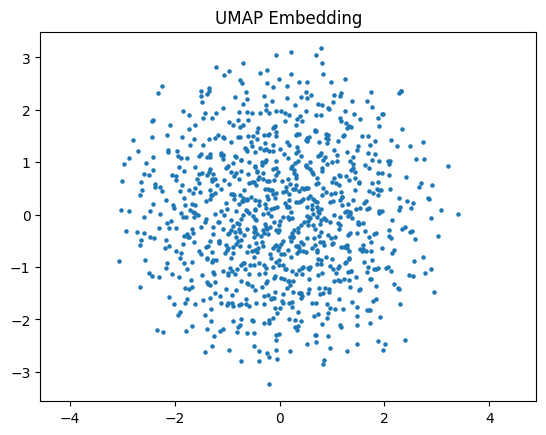

In [172]:
embedding_np = embedding.detach().cpu().numpy()

import matplotlib.pyplot as plt
plt.scatter(embedding_np[:, 0], embedding_np[:, 1], s=5)
plt.title("UMAP Embedding")
plt.axis("equal")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


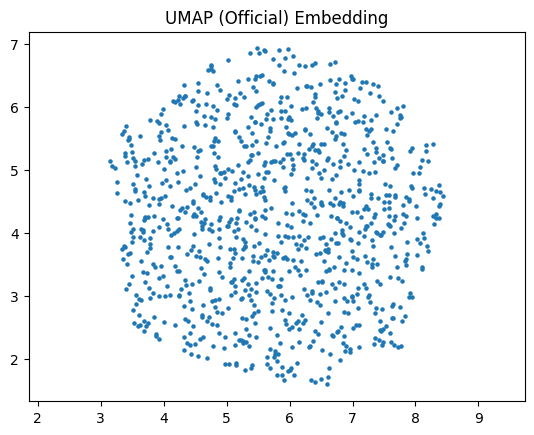

In [161]:
import matplotlib.pyplot as plt
import umap

reducer = umap.UMAP()

embedding_lib = reducer.fit_transform(data)

plt.scatter(embedding_lib[:, 0], embedding_lib[:, 1], s=5)
plt.title("UMAP (Official) Embedding")
plt.axis("equal")
plt.show()

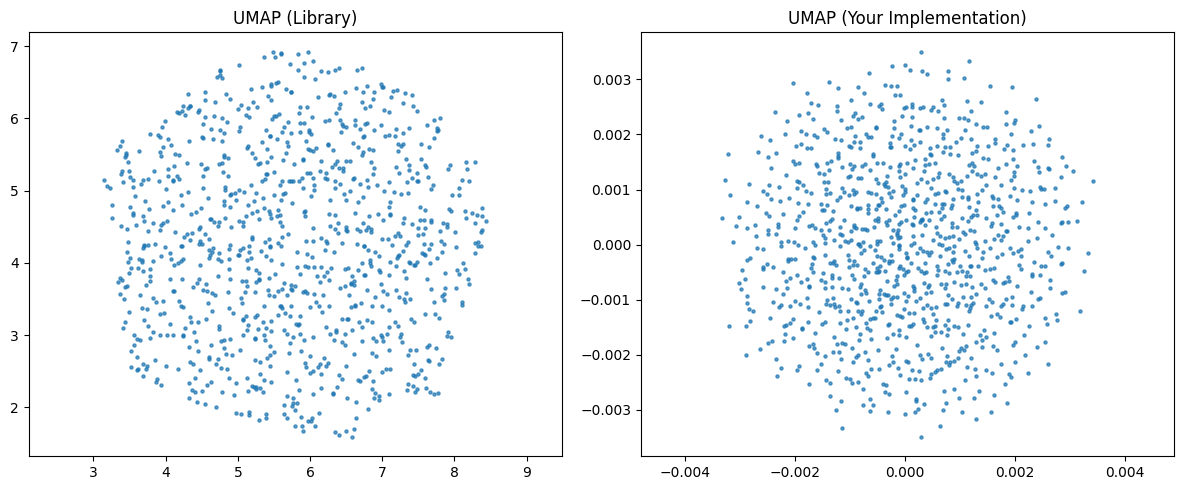

In [164]:
from scipy.spatial import procrustes

# Align them
_, aligned_custom, _ = procrustes(embedding_lib, embedding_np)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(embedding_lib[:, 0], embedding_lib[:, 1], s=5, alpha=0.7)
axs[0].set_title("UMAP (Library)")

axs[1].scatter(aligned_custom[:, 0], aligned_custom[:, 1], s=5, alpha=0.7)
axs[1].set_title("UMAP (Your Implementation)")

for ax in axs:
    ax.axis("equal")

plt.tight_layout()
plt.show()



In [173]:
from sklearn.metrics import pairwise_distances

dist_lib = pairwise_distances(embedding_lib)
dist_custom = pairwise_distances(aligned_custom)

# Compute correlation between the two distance matrices
from scipy.stats import spearmanr
correlation, _ = spearmanr(dist_lib.flatten(), dist_custom.flatten())
print(f"Spearman correlation between distance matrices: {correlation:.4f}")


Spearman correlation between distance matrices: -0.0040
